# 1. Import Library

In [1]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 2. Write Function

In [2]:
def NN_create_WB(A0, HL):
    W = []
    B = []
    for i in range(len(HL)):
        if i == 0:
            W_i = np.random.randn(A0.shape[1], HL[0])/np.sqrt(HL[0])
        else:
            W_i = np.random.randn(HL[i-1], HL[i])/np.sqrt(HL[i])
        B_i = np.random.randn(1, HL[i])/np.sqrt(HL[i])
        W.append(W_i)
        B.append(B_i)
    return W, B

In [3]:
def NNR_find_WB(A0, T, HL, AF, epoch = 1000, lr = 0.01):
    L = len(HL)
    N = A0.shape[0]
    W, B = NN_create_WB(A0, HL)
    error_list = []
    for i in range(epoch):
        Z, A = NN_forward(A0, W, B, AF)
        error = find_error(T, A[-1], 'SSE')
        error_list.append(error)
        SW, SB = NNR_backpropagation(A0, W, B, Z, A, T, AF)
        for j in range(L):
            W[j] = W[j] + (lr/N)*SW[j]
            B[j] = B[j] + (lr/N)*SB[j]
    return W, B, error_list

In [4]:
def NNC_find_WB(A0, T, HL, AF, epoch = 1000, lr = 0.01):
    L = len(HL)
    N = A0.shape[0]
    W, B = NN_create_WB(A0, HL)
    error_list = []
    for i in range(epoch):
        Z, A = NN_forward(A0, W, B, AF)
        error = find_error(T, A[-1], 'Entropy')
        error_list.append(error)
        SW, SB = NNC_backpropagation(A0, W, B, Z, A, T, AF)
        for j in range(L):
            W[j] = W[j] + (lr/N)*SW[j]
            B[j] = B[j] + (lr/N)*SB[j]
    return W, B, error_list

In [5]:
def NN_forward(A0, W, B, AF):
    Z = []
    A = []
    for i in range(len(AF)):
        if i == 0:
            Z_i = np.dot(A0, W[i]) + B[i]
        else:
            Z_i = np.dot(A[-1], W[i]) + B[i]
        A_i = NN_compute_A(Z_i, AF[i])
        Z.append(Z_i)
        A.append(A_i)
    return Z, A

In [6]:
def NN_compute_A(Z_i, af):
    if type(af) == str:
        if af == 'sigmoid':
            A_i = 1/(1 + np.exp(-Z_i))
        elif af == 'tanh':
            A_i = (np.exp(Z_i) - np.exp(-Z_i))/(np.exp(Z_i) + np.exp(-Z_i))
        elif af == 'ReLU':
            A_i = Z_i * (Z_i > 0)
        elif af == 'softmax':
            A_i = np.exp(Z_i)/np.exp(Z_i).sum(axis=1, keepdims = True)
    elif type(af) == list:
        if af[0] == 'PReLU':
            A_i = Z_i * (Z_i > 0) + af[1] * Z_i * (Z_i <= 0)
    return A_i

In [7]:
def NNR_backpropagation(A0, W, B, Z, A, T, AF):
    L = len(AF)
    SW = []
    SB = []
    for i in range(L - 1, -1, -1):
        if i == L - 1:
            Delta_i = T - A[i]
        else:
            Delta_i = np.dot(Err_i, W[i+1].T)
        Diff_i = NN_compute_Diff(Z[i], A[i], AF[i])
        Err_i = NN_compute_Err(Delta_i, Diff_i)
        if i != 0:
            SW_i = np.dot(A[i-1].T, Err_i)
        else:
            SW_i = np.dot(A0.T, Err_i)
        SB_i = Err_i.sum(axis=0)
        SW.append(SW_i)
        SB.append(SB_i)
    return SW[::-1], SB[::-1]

In [8]:
def NNC_backpropagation(A0, W, B, Z, A, T, AF):
    L = len(AF)
    SW = []
    SB = []
    for i in range(L - 1, -1, -1):
        if i == L - 1:
            Delta_i = T - A[i]
            Diff_i = 1
        else:
            Delta_i = np.dot(Err_i, W[i+1].T)
            Diff_i = NN_compute_Diff(Z[i], A[i], AF[i])
        Err_i = NN_compute_Err(Delta_i, Diff_i)
        if i != 0:
            SW_i = np.dot(A[i-1].T, Err_i)
        else:
            SW_i = np.dot(A0.T, Err_i)
        SB_i = Err_i.sum(axis=0)
        print("SB_i >> " + str(SB_i))
        SW.append(SW_i)
        SB.append(SB_i)
    return SW[::-1], SB[::-1]

In [9]:
def NN_compute_Diff(Z_i, A_i, af):
    if type(af) == str:
        if af == 'sigmoid':
            Diff_i = A_i * (1 - A_i)
        elif af == 'tanh':
            Diff_i = 1 - A_i**2
        elif af == 'ReLU':
            Diff_i = (Z_i > 0)
    elif type(af) == list:
        if af[0] == 'PReLU':
            Diff_i = (Z_i > 0) + af[1] * (Z_i <= 0)
    return Diff_i

In [10]:
def NN_compute_Err(Delta_i, Diff_i):
    Err_i = Delta_i * Diff_i
    return Err_i

In [11]:
def find_error(Y, Yhat, TypeOfError):
    if TypeOfError == 'SSE':
        error = find_SSE(Y, Yhat)
    elif TypeOfError == 'MSE':
        error = find_MSE(Y, Yhat)
    elif TypeOfError == 'MAE':
        error = find_MAE(Y, Yhat)
    elif TypeOfError == 'MAPE':
        error = find_MAPE(Y, Yhat)
    elif TypeOfError == 'Entropy':
        error = find_Entropy(Y, Yhat)
    elif TypeOfError == 'Binary':
        error = find_error_bin_class(Y, Yhat)
    elif TypeOfError == 'Multiclass':
        error = find_error_mul_class(Y, Yhat)
    return error

In [12]:
def find_SSE(Y, Yhat):
    SSE = ((Y - Yhat)**2).sum()
    return SSE

In [13]:
def find_MSE(Y, Yhat):
    N = Y.shape[0]
    SSE = ((Y - Yhat)**2).sum()
    MSE = SSE/N
    return MSE

In [14]:
def find_MAE(Y, Yhat):
    N = Y.shape[0]
    MAE = (np.abs(Y - Yhat)).sum()/N
    return MAE

In [15]:
def find_MAPE(Y, Yhat):
    N = Y.shape[0]
    MAPE = np.abs((Y - Yhat)/Y).sum()*100/N
    return MAPE

In [16]:
def find_Entropy(Y, Yhat):
    error = (-Y*np.log(Yhat)).sum()
    return error

In [17]:
def find_error_bin_class(Y, Yhat):
    N = Y.shape[0]
    _Y = np.round(Y, 0)
    _Yhat = np.round(Yhat, 0)
    error = 100*(_Y != _Yhat).sum()/N
    return error

In [18]:
def find_error_mul_class(Y, Yhat):
    N = Y.shape[0]
    Y_argmax = np.argmax(Y, axis=1)
    Yhat_argmax = np.argmax(Yhat, axis=1)
    error = 100*(Y_argmax != Yhat_argmax).sum()/N
    return error

# 3. Normalization

In [19]:
def min4norm(Data):
    _min = Data.min(axis=0)
    return _min.reshape(1, -1)

In [20]:
def max4norm(Data):
    _max = Data.max(axis=0)
    return _max.reshape(1, -1)

In [21]:
def mean4norm(Data):
    _mean = Data.mean(axis=0)
    return _mean.reshape(1, -1)

In [22]:
def std4norm(Data):
    _std = Data.std(axis=0)
    return _std.reshape(1, -1)

In [23]:
def ed4norm(Data):
    _ed = np.sqrt((Data**2).sum(axis=0))
    return _ed.reshape(1, -1)

In [24]:
def minmaxNorm(Data, min_norm, max_norm):
    Data_Norm = (Data - min_norm)/(max_norm - min_norm)
    return Data_Norm

In [25]:
def meanNorm(Data, min_norm, max_norm, mean_norm):
    Data_Norm = (Data - mean_norm)/(max_norm - min_norm)
    return Data_Norm

In [26]:
def standardization(Data, mean_norm, std_norm):
    Data_Norm = (Data - mean_norm)/std_norm
    return Data_Norm

In [27]:
def SUL(Data, ed_norm):
    Data_Norm = Data/ed_norm
    return Data_Norm

In [28]:
def de_minmaxNorm(Data_Norm, min_norm, max_norm):
    Data = Data_Norm*(max_norm - min_norm) + min_norm
    return Data

In [29]:
def de_meanNorm(Data_Norm, min_norm, max_norm, mean_norm):
    Data = Data_Norm*(max_norm - min_norm) + mean_norm
    return Data

In [30]:
def de_standardization(Data_Norm, mean_norm, std_norm):
    Data = Data_Norm*std_norm + mean_norm
    return Data

In [31]:
def de_SUL(Data_Norm, ed_norm):
    Data = Data_Norm*ed_norm
    return Data

# 4. Read Data & Prepare Data

In [104]:
#Data = pd.read_excel('EURUSD Close.xlsx', usecols = 'H:AL', skiprows = range(1, 32))

Data = pd.read_csv('THB_JPY_Close.csv', usecols=["ล่าสุด", "ราคาเปิด", "สูงสุด", "ต่ำสุด", "% เปลี่ยน"],)

In [105]:
Data #Target Close ราคาปิดในวันที่เราสนใจ

,ล่าสุด,ราคาเปิด,สูงสุด,ต่ำสุด,% เปลี่ยน
0,3.5291,3.5341,3.5373,3.5203,-0.0014
1,3.5341,3.5387,3.5529,3.5213,-0.0014
2,3.5391,3.5163,3.5391,3.5163,0.0067
3,3.5156,3.5011,3.5173,3.4947,0.0042
4,3.5010,3.5066,3.5156,3.4971,-0.0017
5,3.5069,3.4908,3.5092,3.4792,0.0048
6,3.4903,3.4998,3.5051,3.4781,-0.0025
7,3.4989,3.4867,3.5034,3.4817,0.0041
8,3.4845,3.4874,3.4876,3.4819,-0.0001
9,3.4848,3.4781,3.5027,3.4711,0.0024


In [106]:
DataMatrix = Data.values

In [107]:
DataMatrix.shape

(157, 5)

In [108]:
D = DataMatrix.shape[1] - 1 #.shape[1] colunm (-1 ตัด Target Close)
D

4

In [109]:
#A0 = DataMatrix[:, :D]
A0 = DataMatrix[:, :1]
A0 

array([[3.5291],
       [3.5341],
       [3.5391],
       [3.5156],
       [3.501 ],
       [3.5069],
       [3.4903],
       [3.4989],
       [3.4845],
       [3.4848],
       [3.4766],
       [3.4605],
       [3.4745],
       [3.4615],
       [3.4727],
       [3.4779],
       [3.4733],
       [3.4705],
       [3.4676],
       [3.4586],
       [3.4667],
       [3.4611],
       [3.4638],
       [3.4521],
       [3.4529],
       [3.4518],
       [3.4292],
       [3.4341],
       [3.4497],
       [3.4426],
       [3.4329],
       [3.4396],
       [3.4393],
       [3.4329],
       [3.4339],
       [3.4562],
       [3.4587],
       [3.4535],
       [3.4654],
       [3.4562],
       [3.4676],
       [3.4748],
       [3.4762],
       [3.4552],
       [3.4704],
       [3.4859],
       [3.4535],
       [3.4613],
       [3.4546],
       [3.4726],
       [3.4514],
       [3.4819],
       [3.4848],
       [3.4851],
       [3.4933],
       [3.4977],
       [3.4945],
       [3.4939],
       [3.4815

In [110]:
T = DataMatrix[:, D:]

In [111]:
A0.shape

(157, 1)

In [112]:
T

array([[-0.0014],
       [-0.0014],
       [ 0.0067],
       [ 0.0042],
       [-0.0017],
       [ 0.0048],
       [-0.0025],
       [ 0.0041],
       [-0.0001],
       [ 0.0024],
       [ 0.0047],
       [-0.004 ],
       [ 0.0038],
       [-0.0032],
       [-0.0015],
       [ 0.0013],
       [ 0.0008],
       [ 0.0008],
       [ 0.0026],
       [-0.0023],
       [ 0.0016],
       [-0.0008],
       [ 0.0034],
       [-0.0002],
       [ 0.0003],
       [ 0.0066],
       [-0.0014],
       [-0.0045],
       [ 0.0021],
       [ 0.0028],
       [-0.0019],
       [ 0.0001],
       [ 0.0019],
       [-0.0003],
       [-0.0065],
       [-0.0007],
       [ 0.0015],
       [-0.0034],
       [ 0.0027],
       [-0.0033],
       [-0.0021],
       [-0.0004],
       [ 0.0061],
       [-0.0044],
       [-0.0045],
       [ 0.0094],
       [-0.0023],
       [ 0.0019],
       [-0.0052],
       [ 0.0061],
       [-0.0088],
       [-0.0008],
       [-0.0001],
       [-0.0023],
       [-0.0013],
       [ 0

In [113]:
A0_Train = A0[:-56, :]
T_Train = T[:-56, :]

In [114]:
A0_Test = A0[-56:, :]
T_Test = T[-56:, :]

# 5. Create Model

In [116]:
min_A0_Train = min4norm(A0_Train)
max_A0_Train = max4norm(A0_Train)
mean_A0_Train = mean4norm(A0_Train)
std_A0_Train = std4norm(A0_Train)
ed_A0_Train = ed4norm(A0_Train)

min_T_Train = min4norm(T_Train)
max_T_Train = max4norm(T_Train)
mean_T_Train = mean4norm(T_Train)
std_T_Train = std4norm(T_Train)
ed_T_Train = ed4norm(T_Train)

In [117]:
A0_Train_Norm = minmaxNorm(A0_Train, min_A0_Train, max_A0_Train)
# A0_Train_Norm = meanNorm(A0_Train, min_A0_Train, max_A0_Train, mean_A0_Train)
# A0_Train_Norm = standardization(A0_Train, mean_A0_Train, std_A0_Train)
# A0_Train_Norm = SUL(A0_Train, ed_A0_Train)

T_Train_Norm = minmaxNorm(T_Train, min_T_Train, max_T_Train)
# T_Train_Norm = meanNorm(T_Train, min_T_Train, max_T_Train, mean_T_Train)
# T_Train_Norm = standardization(T_Train, mean_T_Train, std_T_Train)
# T_Train_Norm = SUL(T_Train, ed_T_Train)

In [118]:
HL = [15, 15, 1]

In [119]:
AF = [['PReLU', 0.5], ['PReLU', 0.5], ['PReLU', 0.5]]

In [120]:
W, B, error_list = NNR_find_WB(A0_Train_Norm, T_Train_Norm, HL, AF, epoch = 40000, lr = 0.02)

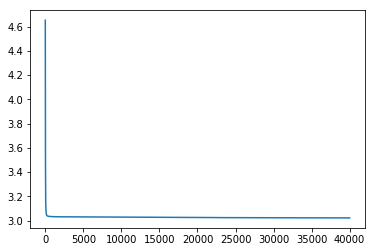

In [121]:
plt.plot(error_list)

In [122]:
Z_Train_Norm, A_Train_Norm = NN_forward(A0_Train_Norm, W, B, AF)

In [123]:
That_Train = de_minmaxNorm(A_Train_Norm[-1], min_T_Train, max_T_Train)
# That_Train = de_meanNorm(A_Train_Norm[-1], min_T_Train, max_T_Train, mean_T_Train)
# That_Train = de_standardization(A_Train_Norm[-1], mean_T_Train, std_T_Train)
# That_Train = de_SUL(A_Train_Norm[-1], ed_T_Train)

In [124]:
error_Train = find_error(T_Train, That_Train, 'MAPE')

C:\Users\Diode\Anaconda3\envs\Ai_101_py3-7\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [125]:
error_Train

inf

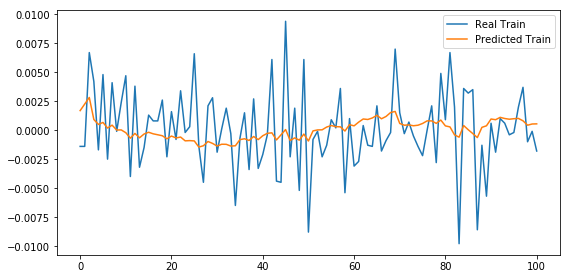

In [126]:
fig = plt.figure(figsize = (9, 4.5))
plt.plot(T_Train, label = 'Real Train')
plt.plot(That_Train, label = 'Predicted Train')
plt.legend()

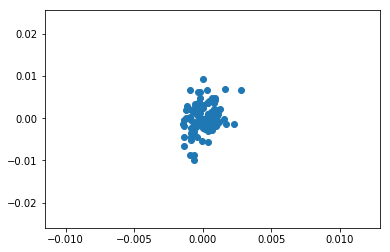

In [127]:
plt.scatter(That_Train, T_Train)

# 6. Make Prediction

In [128]:
A0_Test_Norm = minmaxNorm(A0_Test, min_A0_Train, max_A0_Train)
# A0_Test_Norm = meanNorm(A0_Test, min_A0_Train, max_A0_Train, mean_A0_Train)
# A0_Test_Norm = standardization(A0_Test, mean_A0_Train, std_A0_Train)
# A0_Test_Norm = SUL(A0_Test, ed_A0_Train)

T_Test_Norm = minmaxNorm(T_Test, min_T_Train, max_T_Train)
# T_Test_Norm = meanNorm(T_Test, min_T_Train, max_T_Train, mean_T_Train)
# T_Test_Norm = standardization(T_Test, mean_T_Train, std_T_Train)
# T_Test_Norm = SUL(T_Test, ed_T_Train)

In [129]:
Z_Test_Norm, A_Test_Norm = NN_forward(A0_Test_Norm, W, B, AF)

In [130]:
That_Test = de_minmaxNorm(A_Test_Norm[-1], min_T_Train, max_T_Train)
# That_Test = de_meanNorm(A_Test_Norm[-1], min_T_Train, max_T_Train, mean_T_Train)
# That_Test = de_standardization(A_Test_Norm[-1], mean_T_Train, std_T_Train)
# That_Test = de_SUL(A_Test_Norm[-1], ed_T_Train)

In [131]:
error_Test = find_error(T_Test, That_Test, 'MAPE')

C:\Users\Diode\Anaconda3\envs\Ai_101_py3-7\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [132]:
error_Test

inf

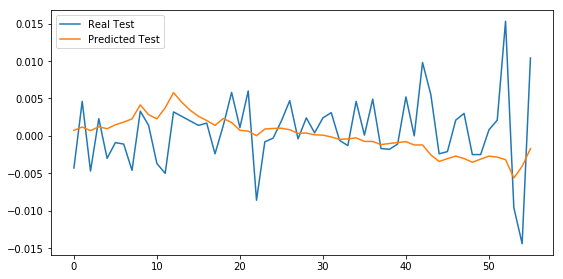

In [133]:
fig = plt.figure(figsize = (9, 4.5))
plt.plot(T_Test, label = 'Real Test')
plt.plot(That_Test, label = 'Predicted Test')
plt.legend()

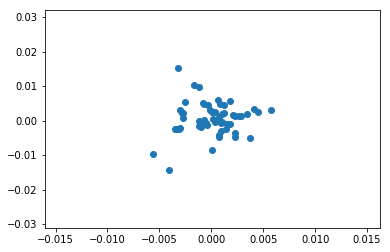

In [134]:
plt.scatter(That_Test, T_Test)

# 7. Zoom Result

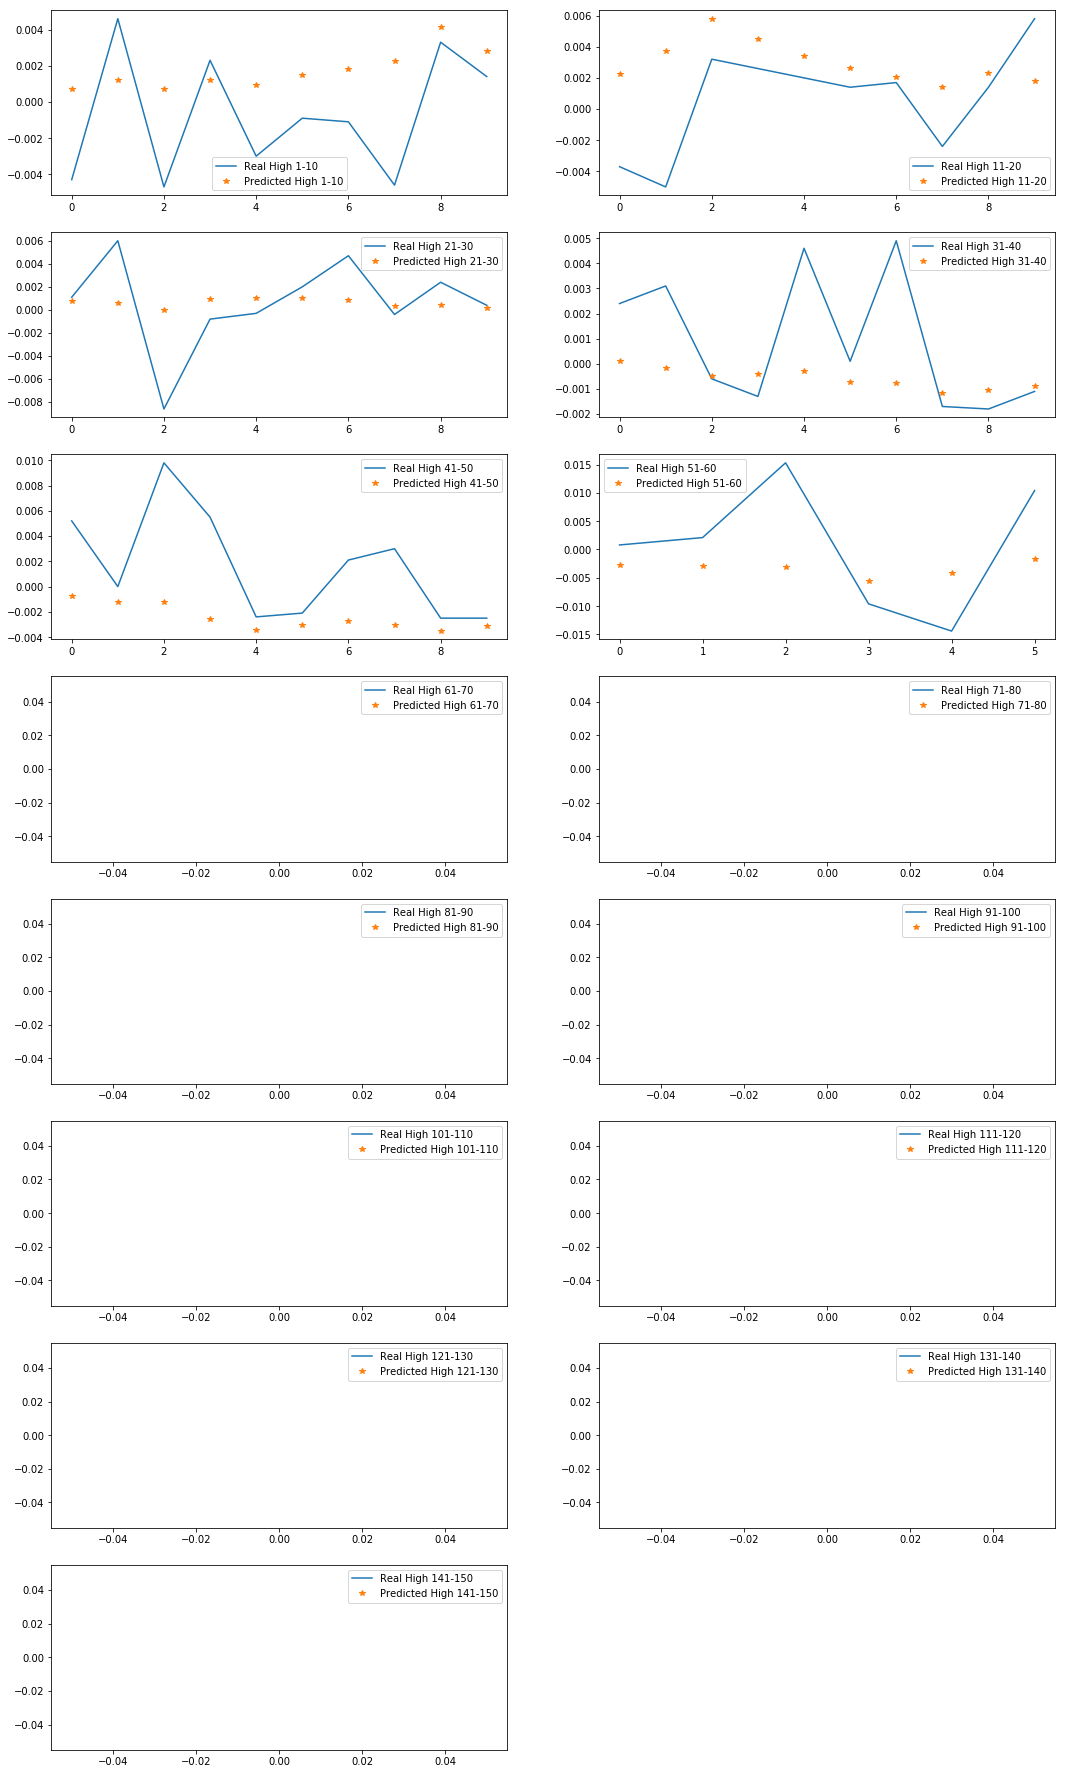

In [135]:
fig = plt.figure(figsize=(18, 32))

for i in range(15):
    plt.subplot(8, 2, i + 1)
    plt.plot(T_Test[10*i: 10*i + 10], label = 'Real High ' + str(i*10 + 1) + '-'  + str(i*10 + 10))
    plt.plot(That_Test[10*i: 10*i + 10], '*', label = 'Predicted High ' + str(i*10 + 1) + '-'  + str(i*10 + 10))
    plt.legend()